In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5_U = ERA5["u"].sel(valid_time="2024-04-02T12:00:00")

In [4]:
import copy


def plot_data(
    da: xr.DataArray,
    title_prefix="",
    title_postfix="",
    error=False,
    n_levels=256,
    cmap=None,
    divergence_point=None,
    levels=None,
    ticks=None,
    chart=None,
    **kwargs,
):
    UNITS = dict(t2m="degC")
    DIVERGENCE_POINT = dict(t2m=0.0)

    units = None if error else UNITS.get(da.name, None)
    divergence_point = (
        divergence_point
        if divergence_point is not None
        else 0.0
        if error
        else DIVERGENCE_POINT.get(da.name, None)
    )

    source = earthkit.plots.sources.XarraySource(da)

    # compute the default style that earthkit.maps would apply
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=units or source.units,
        )
    )

    da_units = style.convert_units(da.values, source.units)

    # modify the style levels to get a smoother colourbar
    style._levels = earthkit.plots.styles.levels.Levels(
        levels
        if levels is not None
        else earthkit.plots.styles.levels.auto_range(
            da_units,
            divergence_point=divergence_point,
            n_levels=n_levels,
        )
    )
    style._legend_kwargs["ticks"] = (
        earthkit.plots.styles.levels.auto_range(
            da_units,
            divergence_point=divergence_point,
            n_levels=10,
        )
        if ticks is None
        else ticks
    )

    style._kwargs.update(kwargs)

    # force the colourmap to coolwarm for error plots
    style._colors = cmap if cmap is not None else "coolwarm" if error else style._colors

    show = chart is None
    if chart is None:
        chart = earthkit.plots.Map()

    # quickplot with the modified style
    chart.quickplot(
        da,
        units=units,
        style=style,
    )

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    chart.title(
        f"{title_prefix}{{variable_name}} on {{time:%d.%m.%Y at %H:%M}}{title_postfix}"
    )

    if show:
        chart.show()

In [5]:
ERA5_U_chunked = ERA5_U.chunk(100)
ERA5_U_chunked

<xarray.DataArray 'u' (pressure_level: 1, latitude: 721, longitude: 1440)> Size: 4MB
dask.array<xarray-<this-array>, shape=(1, 721, 1440), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
    valid_time      datetime64[ns] 8B 2024-04-02T12:00:00
  * longitude       (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * latitude        (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * pressure_level  (pressure_level) float64 8B 500.0
Attributes: (12/20)
    standard_name:                            eastward_wind
    long_name:                                U component of wind
    units:                                    m s**-1
    GRIB_dataType:                            an
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_longitudeOfFirstGridPointInDegrees:  0.0
    GRIB_longitudeOfLastGridPointInDegrees:   359.75
    GRIB_missingValue:                        3.4028234663852886e+38
    GRIB_name:                                U component of wind
    GRIB_shortName:                           u
    GRIB_units:                               m s**-1

In [6]:
dlon = (ERA5_U.longitude[1] - ERA5_U.longitude[0]).item()

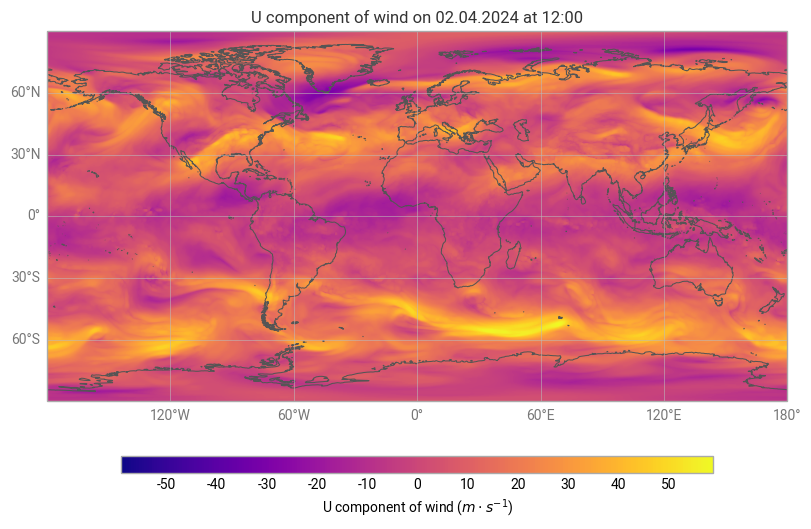

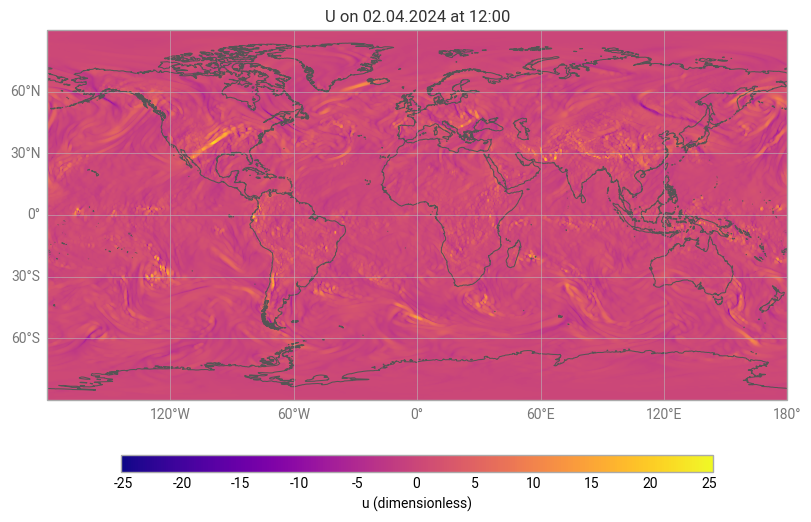

In [7]:
plot_data(ERA5_U, divergence_point=0)
plot_data(ERA5_U.differentiate("longitude"), divergence_point=0)

In [8]:
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

In [9]:
sg = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        dict(
            kind="qoi_eb_stencil",
            qoi=f"finite_difference(x, order=1, accuracy=2, type=0, dx={dlon}, axis=0)",
            neighbourhood=[dict(axis=2, before=1, after=1, boundary="valid")],
            type="abs",
            eb=0.1,
        )
    ],
)

In [10]:
# Safely apply the safeguard to the entire data all at once
ERA5_U_sg = ERA5_U.copy(data=sg.decode(sg.encode(ERA5_U.values)))

In [11]:
"""
The following is UNSAFE since the the QoI stencil safeguard is applied
independently applied to each chunk, risking safety violations at the
chunk boundaries.
"""


def unsafe_encode_decode_data_array_single_chunk(
    da: xr.DataArray,
    codec,
) -> xr.DataArray:
    single_chunk = {dim: -1 for dim in da.dims}

    # return early for zero-sized arrays
    if da.size == 0:
        return da.copy(deep=False).chunk(single_chunk)

    # eagerly compute the input chunk and encode and decode it
    decoded = codec.decode(codec.encode(da.values))  # type: ignore

    return da.copy(deep=False, data=decoded).chunk(single_chunk)


ERA5_U_sg_unsafe_chunked = xr.map_blocks(
    unsafe_encode_decode_data_array_single_chunk, ERA5_U_chunked, kwargs=dict(codec=sg)
).compute()

In [12]:
np.sum(ERA5_U_sg.values != ERA5_U_sg_unsafe_chunked.values)

np.int64(4)

In [13]:
from itertools import product

from numcodecs.abc import Codec

from compression_safeguards import Safeguards
from compression_safeguards.utils.bindings import Bindings
from compression_safeguards.safeguards.pointwise.abc import PointwiseSafeguard
from compression_safeguards.safeguards.stencil import NeighbourhoodAxis
from compression_safeguards.safeguards.stencil.abc import StencilSafeguard

In [14]:
def safe_encode_decode_chunked_data_array(
    da: xr.DataArray,
    codec: Codec,
    safeguards: Safeguards,
) -> xr.DataArray:
    """
    Encoding
    """

    late_bound_reqs = safeguards.late_bound - safeguards.builtin_late_bound

    # compute the late-bound data minimum and maximum
    da_min = np.nanmin(da) if da.size > 0 else np.array(0, dtype=da.dtype)
    da_max = np.nanmin(da) if da.size > 0 else np.array(0, dtype=da.dtype)

    # apply the codec individually to every chunk
    da_decoded = xr.map_blocks(
        unsafe_encode_decode_data_array_single_chunk, da, kwargs=dict(codec=codec),
    )

    # compute the required stencil / neighbourhood for the safeguards
    stencil = [NeighbourhoodAxis(0, 0) for _ in range(len(da.dims))]
    for safeguard in safeguards.safeguards:
        if isinstance(safeguard, StencilSafeguard):
            for i, s in enumerate(safeguard.compute_check_neighbourhood_for_data_shape(da.shape)):
                if s is None:
                    continue
                stencil[i] = NeighbourhoodAxis(before=max(stencil[i].before, s.before), after=max(stencil[i].after, s.after))
        else:
            assert isinstance(safeguard, PointwiseSafeguard), "unknown safeguard kind"

    # we now know that the safeguards have a stencil of [before, ..., x, ..., after]
    # this stencil is sufficient to compute the safeguard to x,
    # BUT the elements from before to after also contribute to the safe intervals of x
    # so we need to ensure that they have all of their stencil available as well
    # therefore we actually need to double the stencil to
    # [before-before, ..., before, ..., x, ..., after, ..., after+after]
    stencil = [NeighbourhoodAxis(before=s.before*2, after=s.after*2) for s in stencil]

    # compute the indices for all chunks
    if da.chunks is None:
        chunk_indices = [[0, a] for a in da.shape]
    else:
        chunk_indices = [[0] + list(int(i) for i in np.cumsum(a)) for a in da.chunks]
    chunk_pairs = [list(zip(a[:-1], a[1:])) for a in chunk_indices]
    chunks = list(product(*chunk_pairs))

    chunk_corrections = []

    for chunk in chunks:
        # compute the chunk indices including the stencil,
        #  and the inside-chunk slicing to remove the stencil again
        chunk_stencil = []
        chunk_unstencil = []
        for (start, end), s, a in zip(chunk, stencil, da.shape):
            new_start = max(0, start - s.before)
            new_end = min(a, end + s.after)
            chunk_stencil.append(slice(new_start, new_end))
            chunk_unstencil.append(slice(start - new_start, end - new_end if new_end != end else None))
        chunk_stencil = tuple(chunk_stencil)
        chunk_unstencil = tuple(chunk_unstencil)

        # materialise the stencil-extended data and encoded data
        chunk_stencil_data = da[chunk_stencil].values
        chunk_stencil_decoded = da_decoded[chunk_stencil].values

        # provide built-in late-bound bindings, including $x_min, $x_max,
        #  and $d for the data dimensions
        late_bound = Bindings.empty()
        if "$x_min" in late_bound_reqs:
            late_bound = late_bound.update(**{"$x_min": da_min})
        if "$x_max" in late_bound_reqs:
            late_bound = late_bound.update(**{"$x_max": da_max})
        for i, d in enumerate(da.dims):
            if f"${d}" in late_bound_reqs:
                shape = [1 for _ in range(len(da.dims))]
                shape[i] = da.shape[i]
                late_bound = late_bound.update(**{f"${d}": da[d][chunk_stencil[i]].values.reshape(shape)})

        # compute the correction for the stencil-extended chunk
        # iff we later discard the correction stencil and only look at the
        #  correction for the chunk, this is safe because:
        #  - pointwise safeguards are always safe to apply independently
        #  - stencil safeguards are safe to apply since we gave them access to
        #    their required stencil of data, and their pointwise corrections
        #    are independent of other corrections
        #  - no other kinds of safeguards are used
        chunk_stencil_correction = safeguards.compute_correction(chunk_stencil_data, chunk_stencil_decoded, late_bound=late_bound)
        chunk_correction = chunk_stencil_correction[chunk_unstencil]

        chunk_corrections.append(chunk_correction)

    """
    Decoding
    """

    da_corrected = da_decoded.copy(deep=True)

    for chunk, chunk_correction in zip(chunks, chunk_corrections):
        chunk_slice = tuple(slice(start, end) for start, end in chunk)
        chunk_decoded = da_decoded[chunk_slice].values
        chunk_corrected = safeguards.apply_correction(chunk_decoded, chunk_correction)

        chunk_check = ERA5_U_sg[chunk_slice].values

        da_corrected[chunk_slice] = chunk_corrected
    
    return da_corrected

In [15]:
ERA5_U_sg_safe_chunked = safe_encode_decode_chunked_data_array(ERA5_U_chunked, sg._codec, Safeguards(safeguards=sg.safeguards)).compute()

In [16]:
np.sum(ERA5_U_sg.values != ERA5_U_sg_safe_chunked.values)

np.int64(0)